In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
import sqlite3
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import os
from tqdm import tqdm

In [ ]:
dataset_dict = load_dataset("imdb")
print(dataset_dict)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


We only gonna use training dataset and split this dataset into train & test splits

In [ ]:
df = pd.DataFrame(dataset_dict['train'][:])
print("shape of the data", df.shape)
print(df.head())

shape of the data (25000, 2)
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [ ]:
conn = sqlite3.connect("imdb_dataset.db")

conn.execute("""
CREATE TABLE IF NOT EXISTS imdb_reviews (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    review_text TEXT NOT NULL,
    sentiment TEXT NOT NULL
)
""")
print("Table imdb_reviews created successfully.")

Table imdb_reviews created successfully.


In [ ]:
for _, row in df.iterrows():
    review_text = row['text']  # 'text' column contains the review text
    sentiment = "positive" if row['label'] == 1 else "negative"  # Convert labels
    conn.execute("INSERT INTO imdb_reviews (review_text, sentiment) VALUES (?, ?)", (review_text, sentiment))

# Commit and close the connection
conn.commit()
print("Data inserted into imdb_reviews successfully.")
conn.close()

Data inserted into imdb_reviews successfully.


In [ ]:
conn = sqlite3.connect("imdb_dataset.db")


query = "SELECT * FROM imdb_reviews"
reviews_df = pd.read_sql_query(query, conn)

conn.close()

In [ ]:
reviews_df.head()

,id,review_text,sentiment
0,1,I rented I AM CURIOUS-YELLOW from my video sto...,negative
1,2,"""I Am Curious: Yellow"" is a risible and preten...",negative
2,3,If only to avoid making this type of film in t...,negative
3,4,This film was probably inspired by Godard's Ma...,negative
4,5,"Oh, brother...after hearing about this ridicul...",negative


# Data Cleaning & Exploration

### Data Cleaning

In [ ]:
reviews_df.drop_duplicates(subset=["review_text"], inplace=True)
reviews_df.dropna(subset=["review_text"], inplace=True)

def clean_text(text):

    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    return text

reviews_df["review_text"] = reviews_df["review_text"].apply(clean_text)

print(reviews_df['review_text'])

0        i rented i am curiousyellow from my video stor...
1        i am curious yellow is a risible and pretentio...
2        if only to avoid making this type of film in t...
3        this film was probably inspired by godards mas...
4        oh brotherafter hearing about this ridiculous ...
                               ...                        
24995    a hit at the time but now better categorised a...
24996    i love this movie like no other another time i...
24997    this film and its sequel barry mckenzie holds ...
24998    the adventures of barry mckenzie started life ...
24999    the story centers around barry mckenzie who mu...
Name: review_text, Length: 24904, dtype: object


### Exploratory Data Analysis (EDA)

In [ ]:
#  Number of Reviews per Sentiment
sentiment_counts = reviews_df["sentiment"].value_counts()
print(sentiment_counts)

sentiment
positive    12472
negative    12432
Name: count, dtype: int64


In [ ]:
# Average Review Length for Positive vs. Negative
reviews_df["review_length"] = reviews_df["review_text"].apply(lambda x: len(x.split()))

average_lengths = reviews_df.groupby("sentiment")["review_length"].mean()
print(average_lengths)


sentiment
negative    225.895672
positive    232.089080
Name: review_length, dtype: float64


### Visualization

Bar Plot: Sentiment Distribution

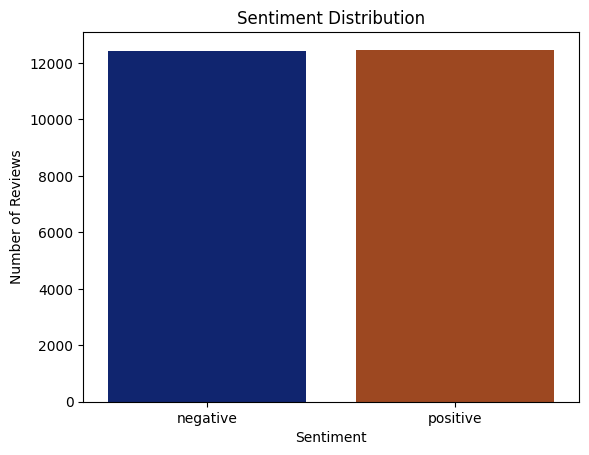

In [ ]:
sns.countplot(x="sentiment", data = reviews_df, palette="dark")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Box Plot: Review Length by Sentiment

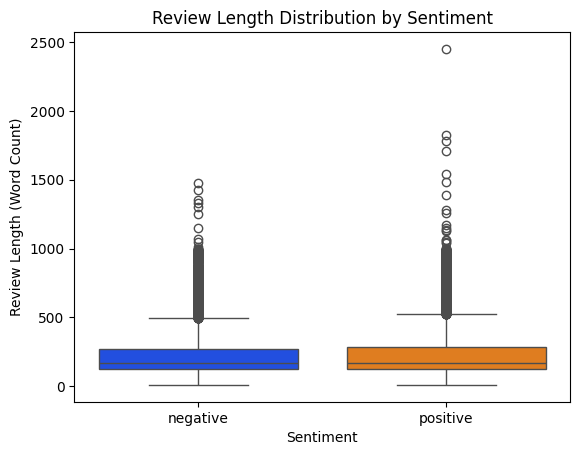

In [ ]:
sns.boxplot(x="sentiment", y="review_length", data=reviews_df, palette="bright")
plt.title("Review Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Length (Word Count)")
plt.show()

In [ ]:
# Convert sentiment to binary (0 or 1)
reviews_df['sentiment'] = (reviews_df['sentiment'] == 'positive').astype(int)

In [ ]:
x = reviews_df['review_text'].values
y = reviews_df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_test.shape

((19923,), (4981,))

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_length):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.valid_indices = list(range(len(self.reviews)))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        try:
            actual_idx = self.valid_indices[idx]
            review = str(self.reviews[actual_idx])
            label = self.sentiments[actual_idx]

            encoding = self.tokenizer(
                review,
                padding='max_length',
                max_length=self.max_length,
                truncation=True,
                return_tensors='pt'
            )

            # Convert label to long tensor (integer) instead of float
            return {
                'input_ids': encoding['input_ids'][0],
                'attention_mask': encoding['attention_mask'][0],
                'labels': torch.tensor(int(label), dtype=torch.long)  # Changed to long
            }

        except (KeyError, IndexError) as e:
            print(f"Skipping problematic index {actual_idx} due to error: {str(e)}")
            self.valid_indices.remove(actual_idx)

            if len(self.valid_indices) > 0:
                return self.__getitem__(idx % len(self.valid_indices))
            else:
                raise RuntimeError("No valid samples remaining in dataset")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_dataset = ReviewsDataset(X_train, y_train, tokenizer, max_length = 512)
test_dataset = ReviewsDataset(X_test, y_test, tokenizer, max_length = 512)

In [ ]:
len(train_dataset), len(test_dataset)

(19923, 4981)

In [ ]:
# Compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
model_name = "textattack/bert-base-uncased-yelp-polarity"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
        output_dir="modernbert_sentiment",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs = 3,
        weight_decay=0.01,
        push_to_hub=False,
        logging_dir='logs',
        logging_steps=100,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to=["none"]
    )

In [ ]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

In [ ]:
print("Training model...")
trainer.train()

Training model...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.244700,0.211791,0.919293,0.914263,0.923887,0.919050
2,0.120500,0.350680,0.916483,0.902114,0.932794,0.917197
3,0.102100,0.409022,0.914274,0.913730,0.913360,0.913545


TrainOutput(global_step=3738, training_loss=0.16403739394320085, metrics={'train_runtime': 6019.382, 'train_samples_per_second': 9.929, 'train_steps_per_second': 0.621, 'total_flos': 1.572588466781184e+16, 'train_loss': 0.16403739394320085, 'epoch': 3.0})

In [ ]:
def save_model(model, output_dir):
    """
    Save only the fine-tuned model to a directory
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save model
    model.save_pretrained(output_dir)

    # Save model state dict separately (optional)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_state_dict.pt'))

    print(f"Model saved to {output_dir}")


save_model(trainer.model, "/content/drive/MyDrive/Assignment data science intern/Finetuned model")

Model saved to /content/drive/MyDrive/Assignment data science intern/Finetuned model


# Evaluation

In [ ]:
test_df = pd.DataFrame(dataset_dict['test'][:])

sample_df = test_df.sample(n=500, random_state=42)



sample_df.drop_duplicates(subset=["text"], inplace=True)
sample_df.dropna(subset=["text"], inplace=True)
sample_df["text"] = sample_df["text"].apply(clean_text)

test_dataset = ReviewsDataset(sample_df['text'].values, sample_df['label'].values, tokenizer, max_length = 512)

In [ ]:
def evaluate_model(model, test_dataset, tokenizer, batch_size=16, device='cuda'):

    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []

    # Create DataLoader for test dataset
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # Disable gradient calculations
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_predictions),
        'precision': precision_score(all_labels, all_predictions),
        'recall': recall_score(all_labels, all_predictions),
        'f1': f1_score(all_labels, all_predictions)
    }

    return metrics


In [ ]:
evaluation_results = evaluate_model(trainer.model, test_dataset, tokenizer)
print(evaluation_results)

Evaluating: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

{'accuracy': 0.924, 'precision': 0.892, 'recall': 0.9529914529914529, 'f1': 0.9214876033057852}
